In [ ]:
#hide
import datetime
import logging
import sys

from fbprophet import Prophet
from loguru import logger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
from pandas._libs.tslibs.timestamps import Timestamp
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.stats.api as sms
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA

import elec_consumption.forecast as forecast

In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6 * 1.61803398875, 6]

logging.disable(sys.maxsize)

data = {
    'zeroHour': None,  # series, hourly power consumption profile of unit 0
    'zeroHourFb': None,  # for Prophet, hourly power consumption profile of unit 0
}  # contain modified dataframes
mod = {
    'zeroDayFb': None,  # for Prophet using daily power consumption profile of unit 0
    'zeroHourFb': None,  # Prophet, using hourly power consumption profile of unit 0
}

# Forecast

Different statistical model can be built for different clusters of households. Forecasts with two different resolutions, hourly and daily, are expected.

In [ ]:
#hide
# Import 500 profiles.
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

## 1. Lag Plot for Household 0

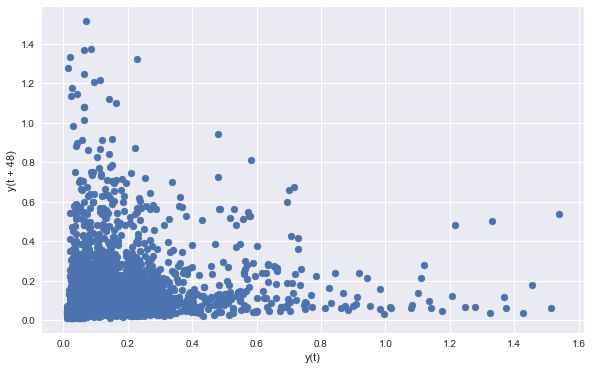

In [ ]:
#hide_input
data['unit0'] = df.iloc[:, 0]
pd.plotting.lag_plot(data['unit0'], lag=48);

## 2. Daily Profile of Household 0

In [ ]:
# To pandas time series
data['tsPdDaily'] = df.iloc[:, 0].resample('1D', closed='left').mean()

### using Facebook Prophet  

In [ ]:
#hide
ts_fb = data['tsPdDaily'].to_frame().reset_index()  # to Prophet time series
ts_fb.columns = ['ds', 'y']

In [ ]:
#hide
mod['zeroDayFb'] = Prophet()
mod['zeroDayFb'].fit(ts_fb)

Forcasts and confidence intervals for future 3 days:

In [ ]:
#hide
df_future = mod['zeroDayFb'].make_future_dataframe(periods=3)
df_forecast = mod['zeroDayFb'].predict(df_future)

In [ ]:
#hide_input
res = df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)
res['ds'] = res['ds'].apply(lambda x: x.date())
res = res.set_index('ds')
res.index.name = 'date'
res

,yhat,yhat_lower,yhat_upper
date,,,
2017-12-01,0.135803,0.090507,0.183967
2017-12-02,0.159741,0.113121,0.206237
2017-12-03,0.154350,0.106185,0.200574


Line plot for forecasts and confidence interval of future 3 days.

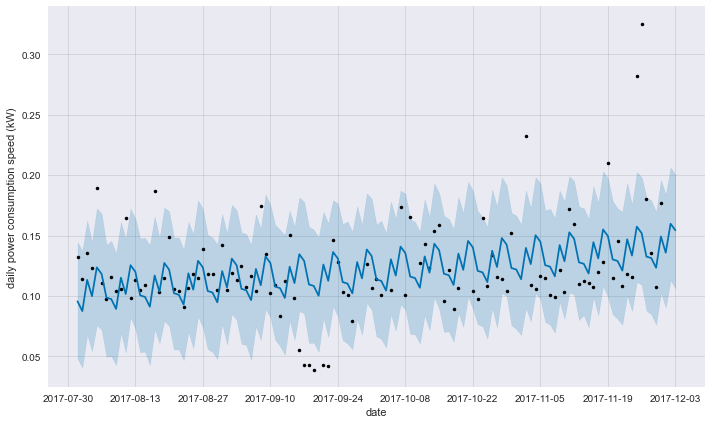

In [ ]:
#hide_input
mod['zeroDayFb'].plot(
    df_forecast, xlabel='date', ylabel='daily power consumption speed (kW)'
);

Trending and weekly cycling components in the model.

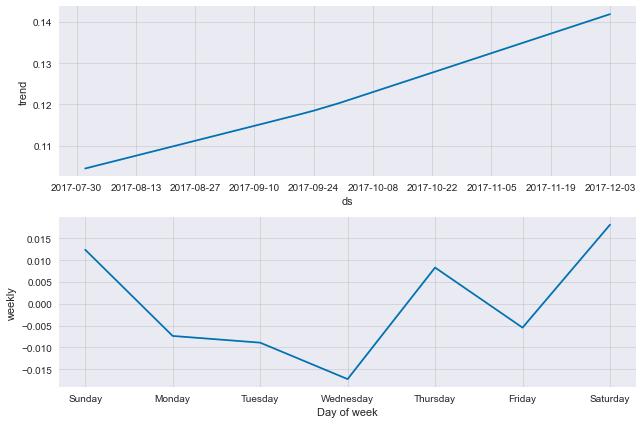

In [ ]:
#hide_input
mod['zeroDayFb'].plot_components(df_forecast);

### Residual Analysis for Prophet Model

In [ ]:
#hide
data['resDaily'] = df_forecast.loc[:121, ['ds', 'yhat']]
data['resDaily'].set_index('ds', inplace=True)
data['resDaily']['yhat'] = data['resDaily']['yhat'] - data['tsPdDaily']
data['resDaily'].columns = ['resid']
data['resDaily']['resid'].fillna(0, inplace=True)

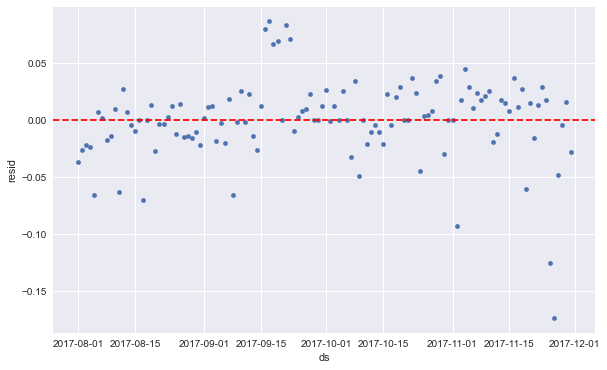

In [ ]:
#hide
_, ax = plt.subplots(1, 1)
data['resDaily'].reset_index().plot.scatter(x='ds', y='resid', ax=ax);
ax.axhline(0, ls='--', color='r');

There is some information left shown by ACF.

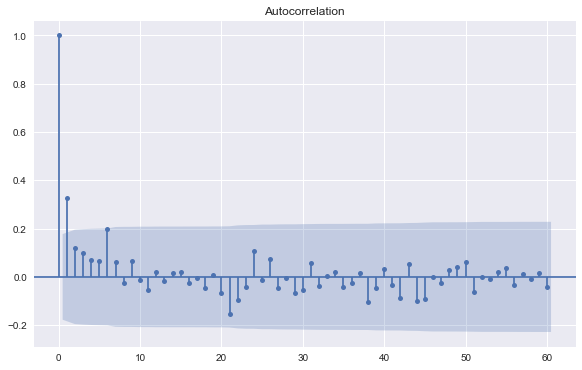

In [ ]:
#hide_input
plot_acf(data['resDaily'], lags=60);

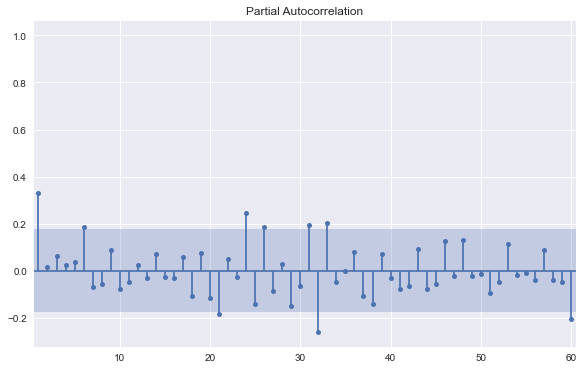

In [ ]:
#hide
fig, ax = plt.subplots(1, 1)
fig = plot_pacf(data['resDaily'], lags=60, ax=ax);
ax.set_xlim([0.5, 60.5]);

### Model with Seasonal ARIMA

It is impossible to plot ACF and PACF for original data because there are NaN.

A (1, 0, 0) + ((1, 0, 0, 7) SARIMA model is built.

In [ ]:
#hide
fit = ARIMA(
    endog=data['tsPdDaily'], order=(1, 0, 0), freq='D', seasonal_order=(1, 0, 0, 7)
).fit()

There is nothing left according to ACF and PACF.

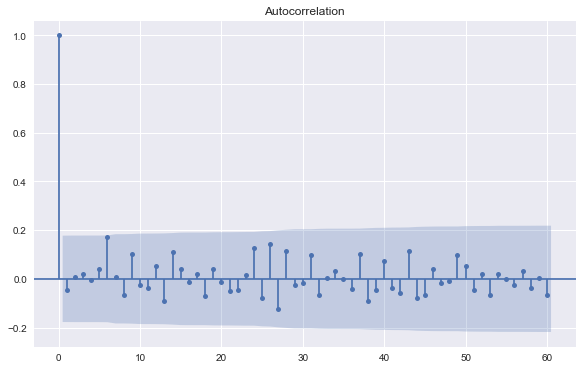

In [ ]:
#hide_input
_, ax = plt.subplots(1, 1)
plot_acf(fit.resid.fillna(0), lags=60, ax=ax);

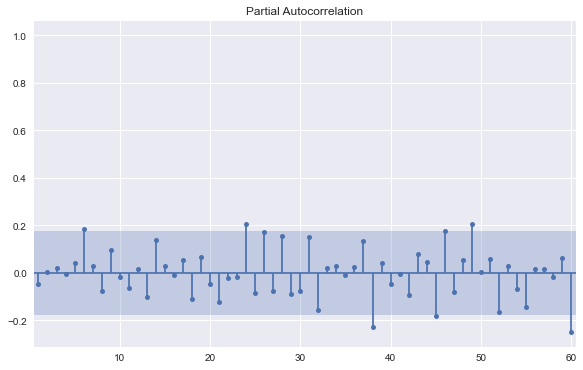

In [ ]:
#hide_input
_, ax = plt.subplots(1, 1)
plot_pacf(fit.resid.fillna(0), lags=60, ax=ax);
ax.set_xlim([0.5, 60.5]);

In [ ]:
#hide_input
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                  122
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood                 208.944
Date:                         Thu, 17 Dec 2020   AIC                           -409.887
Time:                                 15:50:08   BIC                           -398.671
Sample:                             08-01-2017   HQIC                          -405.331
                                  - 11-30-2017                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1231      0.008     14.873      0.000       0.107       0.139
ar.L1          0.4191      0.077      5.469      0.000       0.269       0.569
ar.S.L7        0.1474      0.141      1.043      0.297      -0.129       0.424
sigma2         0.0013      0.000      9.418      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               132.87
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                             1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pseudo-Out-of-Sample Model Validation

MSE of 3-step forecast using Facebook Prophet:

In [ ]:
#hide
frames = []
for i in range(97, 119):
    frames.append(
        forecast.validate(forecast.fit_prophet, data['tsPdDaily'], i)
    )

In [ ]:
#hide_input
# Result is 0.003558756357791278.
res = pd.concat(frames)
(res['resid']**2).mean()

0.003558756357791278

Here is MSE of 3-step forecast using seasonal ARIMA, which is 7.736 % higher than MSE using Prophet.

In [ ]:
#hide
frames = []
for i in range(97, 119):
    frames.append(
        forecast.validate(forecast.fit_sarima, data['tsPdDaily'], i)
    )

In [ ]:
#hide_input
# Result is 0.003834059794252662.
res = pd.concat(frames)
(res['resid']**2).mean()

0.003834059794252662

## 3. Facebook Prophet for Hourly Profile of Household 0

In [ ]:
#hide
data['zeroHour'] = df.iloc[:, 0].resample('1H', closed='left').mean()  # to pandas time series
data['zeroHourFb'] = data['zeroHour'].to_frame().reset_index()  # to Prophet time series
data['zeroHourFb'].columns = ['ds', 'y']
mod['zeroHourFb'] = Prophet()
mod['zeroHourFb'].fit(data['zeroHourFb'])

In [ ]:
#hide
df_future = mod['zeroHourFb'].make_future_dataframe(
    periods=24, freq='H', include_history=True
)
df_forecast = mod['zeroHourFb'].predict(df_future)

In [ ]:
#hide
# Store endogenous variables, in-sample predictions, and residuals in one dataframe.
data['zeroHourFbResid'] = df_forecast.loc[
    df_forecast['ds'] < Timestamp('2017-12-01 00:00:00'),
    ['ds', 'yhat']
]
data['zeroHourFbResid'].set_index('ds', inplace=True)
data['zeroHourFbResid'].index.name = 'datetime'
data['zeroHourFbResid']['y'] = data['zeroHour']
data['zeroHourFbResid']['resid'] = data['zeroHourFbResid']['y'] - data['zeroHourFbResid']['yhat']

# Drop rows with NaN.
# data['zeroHourFbResid'].dropna(inplace=True)
# assert data['zeroHourFbResid'].shape == (2664, 3)

For example, out-of-sample forecasts for future 4 hours are:

In [ ]:
#hide_input
res = df_forecast.loc[2928:2931, ['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
res.set_index('ds', inplace=True)
res.index.name = 'datetime'
res

,yhat,yhat_lower,yhat_upper
datetime,,,
2017-12-01 00:00:00,0.157450,0.030500,0.283480
2017-12-01 01:00:00,0.135131,-0.002964,0.272041
2017-12-01 02:00:00,0.115922,-0.018946,0.255922
2017-12-01 03:00:00,0.108154,-0.029522,0.242961


Here is a line plot for out-of-sample forecasts and confidence intervals of future 24 hours.

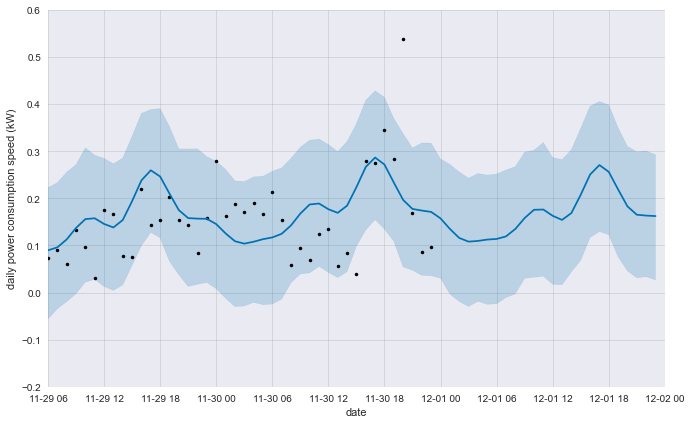

In [ ]:
#hide_input
_, ax = plt.subplots(1, 1)
ax.set_xlim([Timestamp('2017-11-29 06:00:00'), Timestamp('2017-12-02 00:00:00')])
ax.set_ylim([-0.2, 0.6])
mod['zeroHourFb'].plot(
    df_forecast, ax=ax, xlabel='date', ylabel='daily power consumption speed (kW)'
);

Here are plots for one trending and two seasonality components.

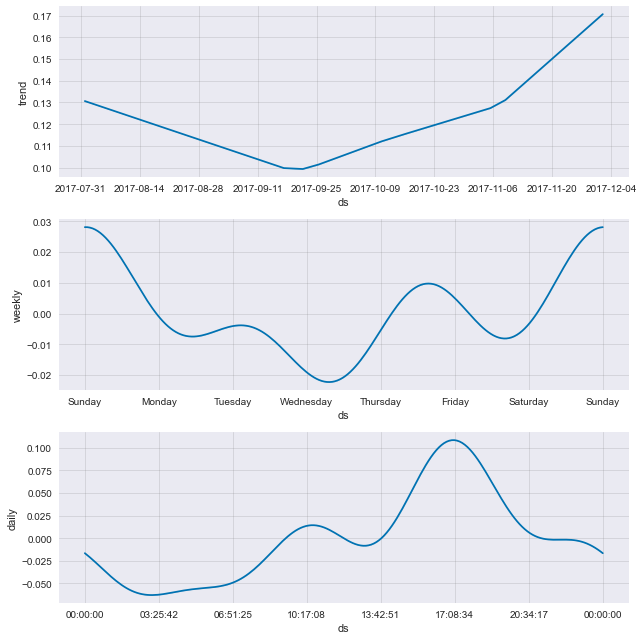

In [ ]:
#hide_input
mod['zeroHourFb'].plot_components(df_forecast);

Unfortunately, it is impossible to apply seasonal ARIMA, because of multiple seasonality.

### Specification Tests

The assumption that residuals from Prophet model is rejected.

In [ ]:
#hide_input
sms.jarque_bera(data['zeroHourFbResid']['resid'])[1] < 0.05

False

According to White's test for Heteroscedasticity, variance of residuals does vary with power consumptions.

In [ ]:
#hide_input
sms.het_white(
    data['zeroHourFbResid']['resid'], add_constant(data['zeroHourFbResid']['y'])
)[1] < 0.05

MissingDataError: exog contains inf or nans

As suggested by the previous test, variance of residuals increases with respect to power consumptions. That is, when power consumption is high, the in-sample forcast is expected to have a high residual. The same goes for out-of-sample forecasts.

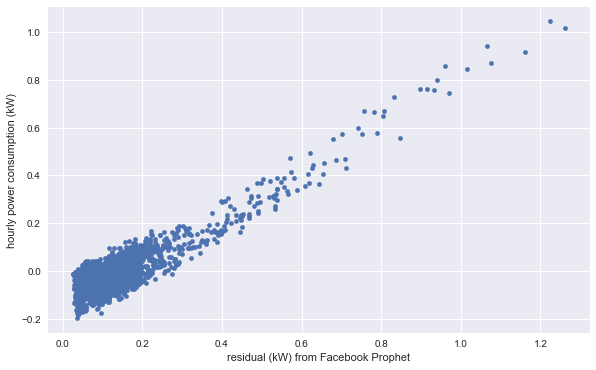

In [ ]:
ax = data['zeroHourFbResid'].plot(x='y', y='resid', kind='scatter');
ax.set_xlabel("residual (kW) from Facebook Prophet");
ax.set_ylabel("hourly power consumption (kW)");

### Autocorrelation Tests and ARIMA Model

All the Ljung-Box tests for lags 1, 2, 3, 4, 5, 24, and 168 reject the assumption that the residual is not correlated.

In [ ]:
#hide_input
[
    pvalue < 0.05
    for pvalue in sms.acorr_ljungbox(
        data['zeroHourFbResid']['resid'].fillna(0), lags=[1, 2, 3, 4, 5, 24, 168]
    )[1].tolist()
]

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


[True, True, True, True, True, True, True]

The test is supported by ACF.

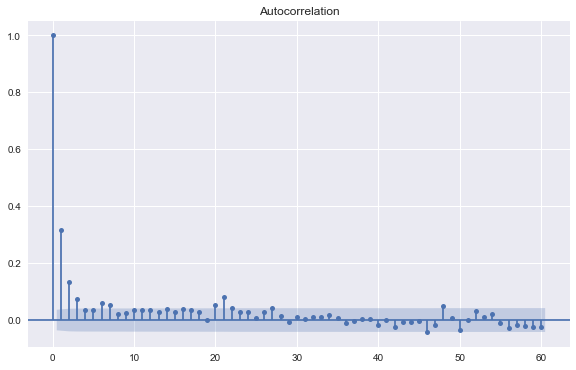

In [ ]:
#hide_input
plot_acf(data['zeroHourFbResid']['resid'].fillna(0), lags=60);

A SARIMA (1, 0, 0) (1, 0, 1, 24) can be used to model it.

In [ ]:
#hide
fit = ARIMA(
    endog=data['zeroHourFbResid']['resid'].fillna(0), order=(1, 0, 0),
    freq='H', seasonal_order=(1, 0, 1, 24),
).fit()

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


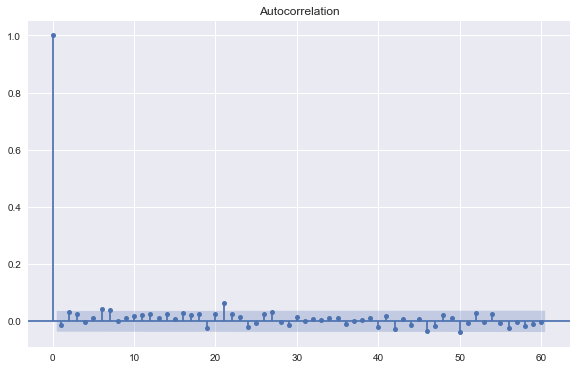

In [ ]:
#hide_input
plot_acf(fit.resid, lags=60);

In [ ]:
#hide_input
[
    pvalue < 0.05
    for pvalue in sms.acorr_ljungbox(fit.resid, lags=[1, 2, 3, 4, 5, 24, 168])[1].tolist()
]

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


[False, False, False, False, False, True, True]

In [ ]:
#hide_input
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              resid   No. Observations:                 2928
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood                2740.060
Date:                            Thu, 17 Dec 2020   AIC                          -5470.119
Time:                                    17:02:09   BIC                          -5440.209
Sample:                                08-01-2017   HQIC                         -5459.347
                                     - 11-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.445e-05      0.009      0.005      0.996      -0.017       0.017
ar.L1          0.3254      0.008     40.291      0.000       0.310       0.341
ar.S.L24       0.9902      0.004    236.527      0.000       0.982       0.998
ma.S.L24      -0.9677      0.008   -119.830      0.000      -0.984      -0.952
sigma2         0.0090   7.72e-05    116.406      0.000       0.009       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):            117272.85
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                             4.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""